In [29]:
import pandas as pd
import numpy as np
import pickle
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import plot_roc_curve
from sklearn import datasets, metrics, model_selection

from keras.models import Sequential
from keras.layers import Dense,  Activation
from keras.regularizers import L1L2
from keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from scipy import stats
import seaborn as sns

In [40]:
####Reading data from csv files of neighborhoods
output_feats = 'flat_neighbourhoods_1.csv'
df_iter = pd.read_csv(output_feats,header=None,index_col=0)
output_feats2 = 'flat_neighbourhoods_3.csv'
df_iter1 = pd.read_csv(output_feats,header=None,index_col=0)
df_iter = df_iter.append(df_iter1)
len(df_iter)

#print(df_iter)
X_all = df_iter.iloc[:, :63]
y_all = df_iter.iloc[:, 63:]
print(len(X_all))
print(len(y_all))

X_all = StandardScaler().fit_transform(X_all)
X_sel,X_test, y_sel, y_test = \
        train_test_split(X_all, y_all, test_size=40,random_state=42)

print(len(X_sel),len(X_test))

2880
2880
2840 40


In [32]:
####Definition of MLP-LR classifier in Keras
def MLP_LR_NN (X_train,y_train):
    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoded_Y = encoder.transform(y_train)
    model = Sequential()

    model.add(Dense(63, activation='relu',kernel_regularizer=L1L2(l1=0.0, l2=0.1),
                   input_dim = len(X_train[0])))
    model.add(Dense(1,  # output dim is 2, one score per each class
                    activation='sigmoid',
                    kernel_regularizer=L1L2(l1=0.0, l2=0.1),
                    input_dim=20))  # input dimension = number of features your data has
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    history = model.fit(X_train, encoded_Y, epochs=70, batch_size = 20,verbose = 0)
    return model,history

####Plotting accuracy
def plot_data(dat,plotWhat,y_label,title):
    
    d1 = pd.DataFrame(columns = ['classifier', 'n', plotWhat, 'color'])

    k = 0
    for ni in np.unique(dat['n']):
        for cl in np.unique(dat['classifier']):

            tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', plotWhat]]
            se = stats.sem(tmp[plotWhat].astype(float))
            list(tmp.mean())
            d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
            k += 1


    sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
    fig, ax = plt.subplots(figsize = (8,6))

    for key in names.keys():
        grp = d1[d1['classifier'] == key]
        ax = grp.plot(ax=ax, kind='line', x='n', y=plotWhat, label=key, \
                c = names[key], alpha =0.65)
        ax.set_xscale('log')

    plt.legend(loc='top left',title='Algorithm')
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel('Number of Training Samples')
    plt.show()

In [35]:
###Training
names = {"MLP-LR": "black", "LR":"blue", "MLP-relu-LR":'red'}

ncores=1
num_runs=2
n_est=100
filename = 'Non_linear_classification2.csv'

classifiers = [MLPClassifier(hidden_layer_sizes = 4,activation = 'logistic', alpha=1, max_iter=1000),
               LogisticRegression(max_iter=2000),
               MLP_LR_NN (X_train,y_train)
    ]

# Train each classifier on each data set size, then test
## Prep output file:
f = open(filename, 'w+')
f.write("classifier,n,Accuracy,trainTime,testTime,iterate\n")
f.flush()

ns = np.array([10,100,500,1000,1500,2000,2500,2800])
runList = [(clf) for clf in zip(classifiers, [key for key in names])]
for n in tqdm(ns):
    print (n)
    for iteration in tqdm(range(num_runs)):
        
        #sampling of data
        X_train = X_sel[:n]
        y_train = np.array(y_sel[:n]).ravel()
        
        #X = X_train2[:n,:]
        #y = Y_train2[:n]

        print (iteration)
        for clf in tqdm(runList):
            
            if(clf[1] == "MLP-relu-LR" ):
                trainStartTime = time.time()
                cls,his = MLP_LR_NN (X_train,y_train)
                trainEndTime = time.time()
                trainTime = trainEndTime - trainStartTime
                encoder = LabelEncoder()
                encoder.fit(y_test)
                en_y_test = encoder.transform(y_test)
                
                testStartTime = time.time()
                score = cls.evaluate(X_test, en_y_test, batch_size=20)
                testEndTime = time.time()
                testTime = testEndTime - testStartTime
                acc=score[1]
            else:
                #training
                trainStartTime = time.time()
                clf[0].fit(X_train, y_train)
                trainEndTime = time.time()
                trainTime = trainEndTime - trainStartTime
                #prediction
                testStartTime = time.time()
                out = clf[0].predict(X_test)
                testEndTime = time.time()
                testTime = testEndTime - testStartTime
                #accuracy
                acc = accuracy_score(y_test,out)

            
            #writing to file
            ####("variable,num of training samples,Lhat,avg precision,trainTime,testTime,iterate")
            f.write(f"{clf[1]}, {n}, {acc:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
            f.flush()
f.close()

  0%|                                                                                         | 0/2 [00:00<?, ?it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|███████████████████████████                                                      | 1/3 [00:00<00:00,  8.50it/s]

10
0
40/40 [==============================] - 0s 449us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.66it/s]

 50%|████████████████████████████████████████▌                                        | 1/2 [00:00<00:00,  1.54it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1
40/40 [==============================] - 0s 384us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.88it/s]

  0%|                                                                                         | 0/2 [00:00<?, ?it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|███████████████████████████                                          

100
0
40/40 [==============================] - 0s 448us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.16it/s]

 50%|████████████████████████████████████████▌                                        | 1/2 [00:00<00:00,  1.05it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1
40/40 [==============================] - 0s 673us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.07it/s]

  0%|                                                                                         | 0/2 [00:00<?, ?it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

500
0




 33%|███████████████████████████                                                      | 1/3 [00:00<00:00,  3.99it/s]

40/40 [==============================] - 0s 474us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]

 50%|████████████████████████████████████████▌                                        | 1/2 [00:02<00:02,  2.79s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1
40/40 [==============================] - 0s 449us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s]

  0%|                                                                                         | 0/2 [00:00<?, ?it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|███████████████████████████                                          

1000
0
40/40 [==============================] - 0s 438us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]

 50%|████████████████████████████████████████▌                                        | 1/2 [00:04<00:04,  4.43s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]



1


 33%|███████████████████████████                                                      | 1/3 [00:00<00:00,  5.67it/s]

40/40 [==============================] - 0s 449us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.47s/it]

  0%|                                                                                         | 0/2 [00:00<?, ?it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1500
0




 33%|███████████████████████████                                                      | 1/3 [00:00<00:00,  5.39it/s]

40/40 [==============================] - 0s 499us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.04s/it]

 50%|████████████████████████████████████████▌                                        | 1/2 [00:06<00:06,  6.11s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1




 33%|███████████████████████████                                                      | 1/3 [00:00<00:00,  4.94it/s]

40/40 [==============================] - 0s 424us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.84s/it]

  0%|                                                                                         | 0/2 [00:00<?, ?it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

2000
0




 33%|███████████████████████████                                                      | 1/3 [00:00<00:00,  2.53it/s]

40/40 [==============================] - 0s 424us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.78s/it]

 50%|████████████████████████████████████████▌                                        | 1/2 [00:08<00:08,  8.35s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1




 33%|███████████████████████████                                                      | 1/3 [00:00<00:00,  2.35it/s]

40/40 [==============================] - 0s 366us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.76s/it]

  0%|                                                                                         | 0/2 [00:00<?, ?it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

2500
0




 33%|███████████████████████████                                                      | 1/3 [00:00<00:00,  2.62it/s]

40/40 [==============================] - 0s 448us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.55s/it]

 50%|████████████████████████████████████████▌                                        | 1/2 [00:10<00:10, 10.66s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1




 33%|███████████████████████████                                                      | 1/3 [00:00<00:00,  3.67it/s]

40/40 [==============================] - 0s 399us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.42s/it]

  0%|                                                                                         | 0/2 [00:00<?, ?it/s]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

2800
0




 33%|███████████████████████████                                                      | 1/3 [00:00<00:01,  1.80it/s]

40/40 [==============================] - 0s 500us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.77s/it]

 50%|████████████████████████████████████████▌                                        | 1/2 [00:11<00:11, 11.32s/it]

  0%|                                                                                         | 0/3 [00:00<?, ?it/s]

1




 33%|███████████████████████████                                                      | 1/3 [00:00<00:00,  2.07it/s]

40/40 [==============================] - 0s 473us/step


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.93s/it]

100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [01:29<00:00, 11.22s/it]


C:\Users\sanik\Anaconda3\envs\brainlight\lib\site-packages\ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Unrecognized location 'top left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


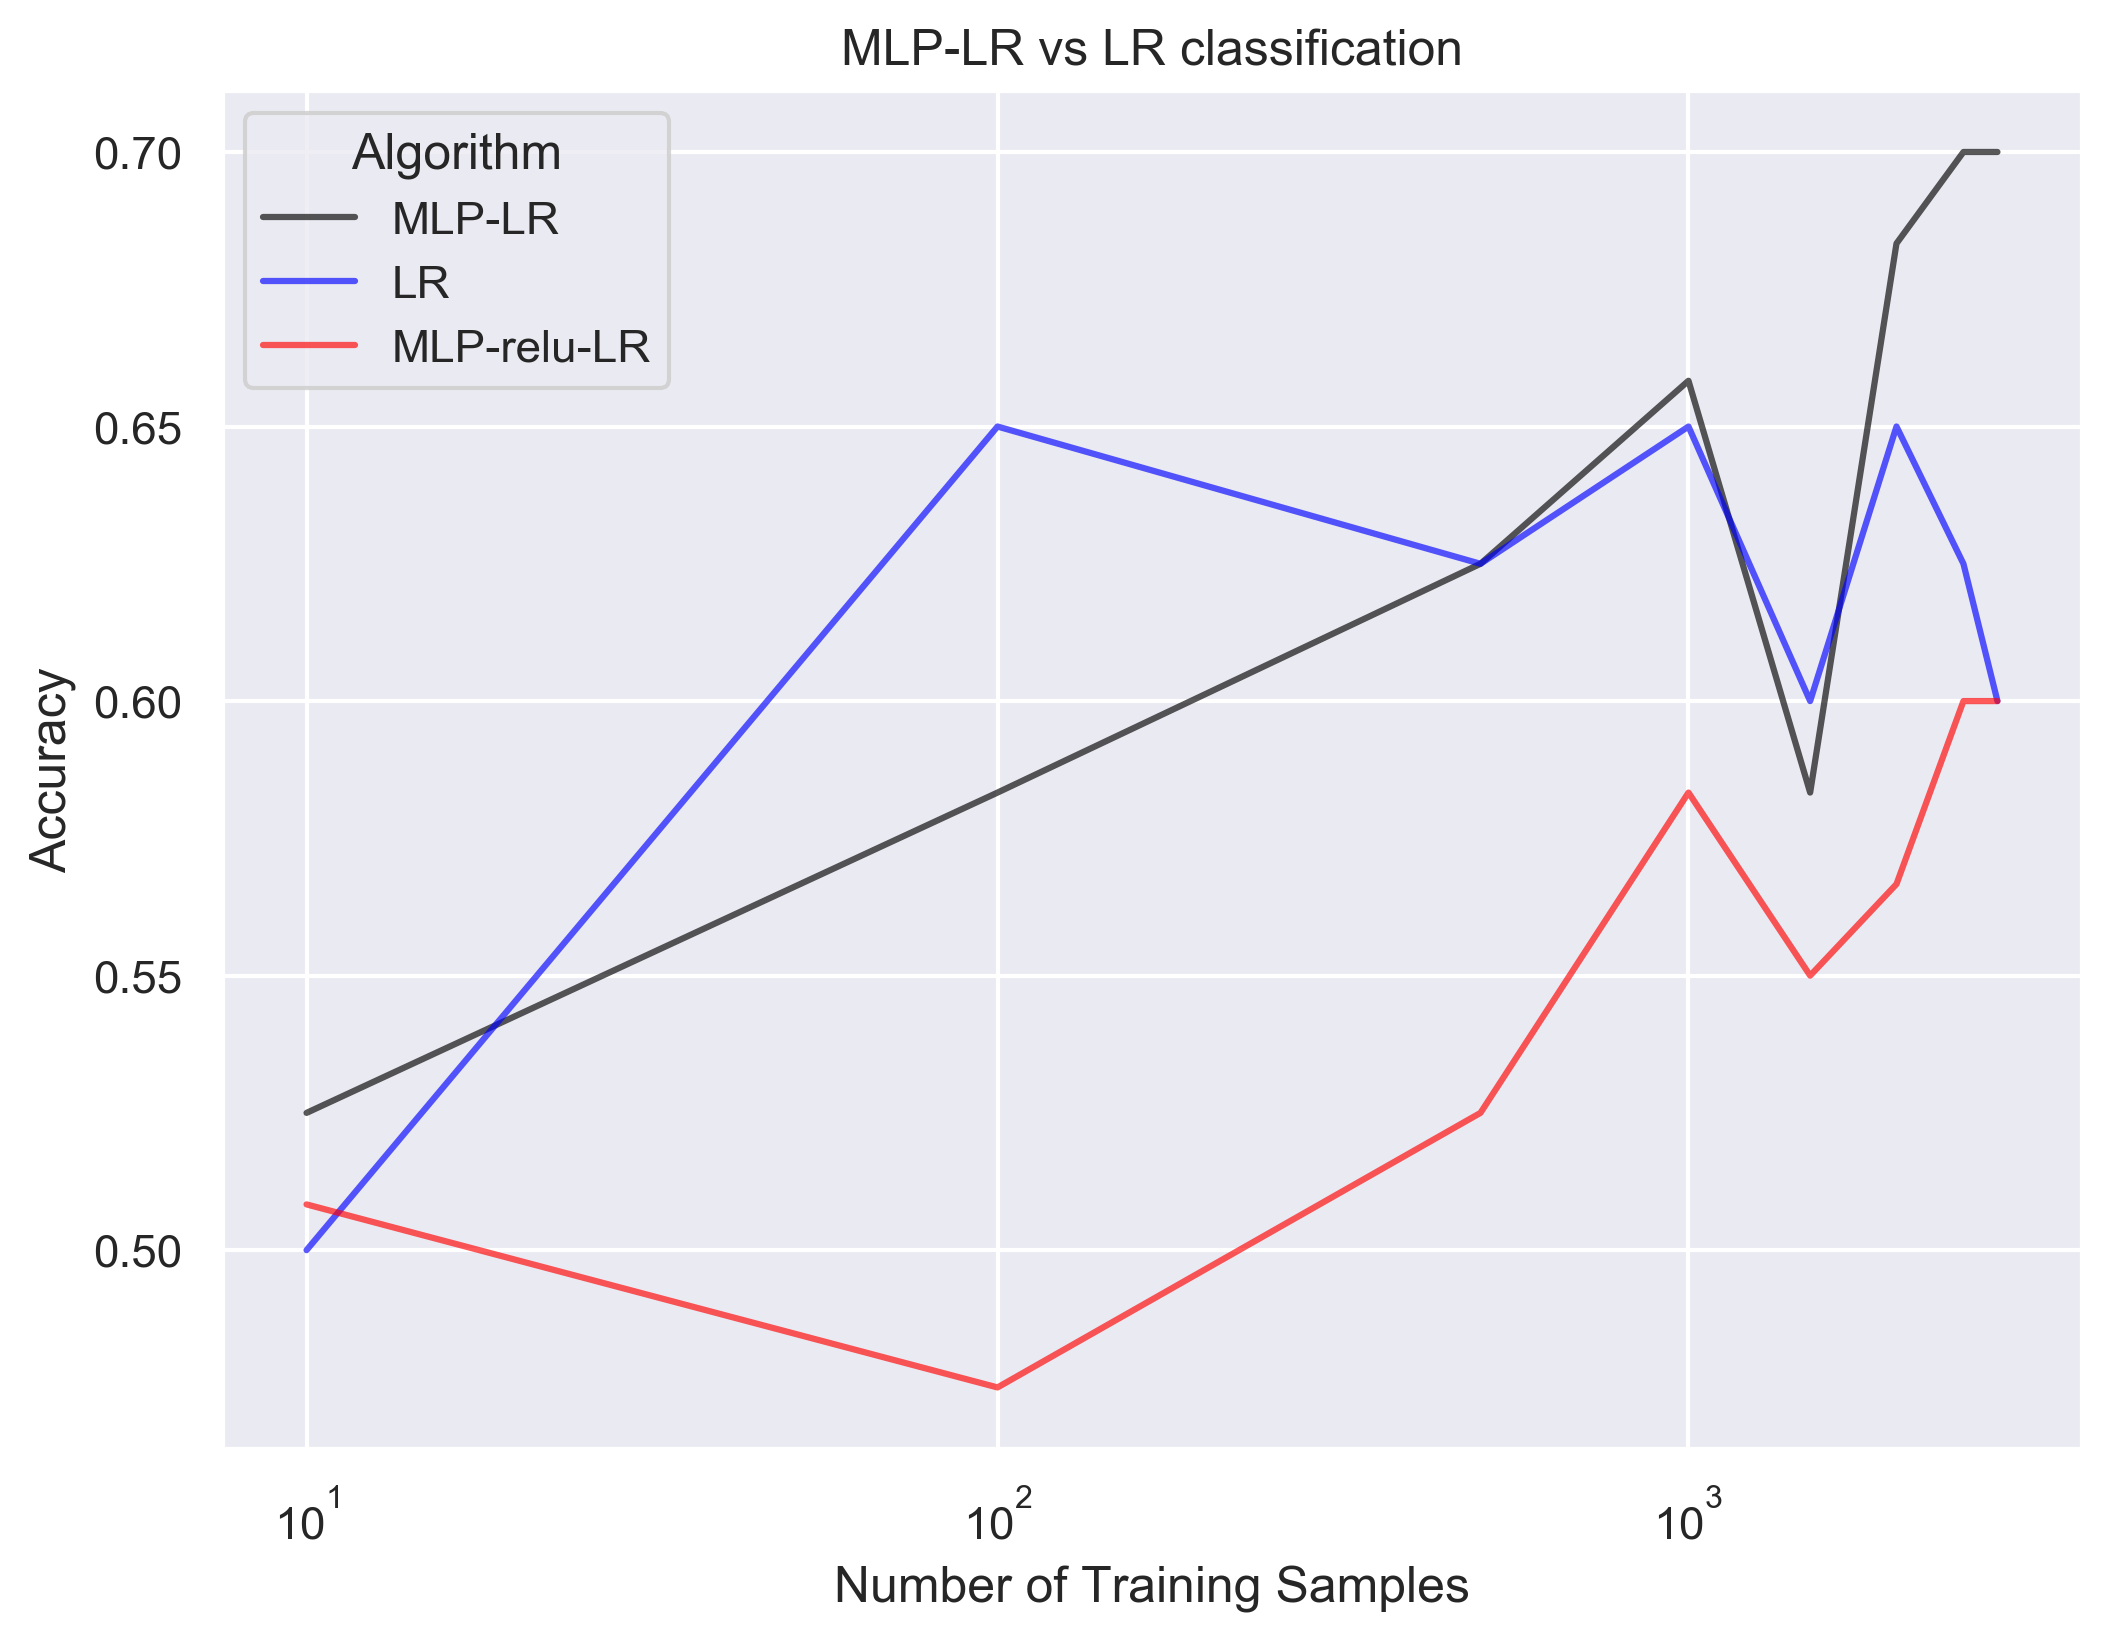

In [38]:
#names = {"kNN": "black", "RF":"blue", "MLP":"green", "S-RerF":"red"}
#filename = 'Non_linear_classification1.csv'
dat = pd.read_csv(filename)

##Plot Average Precision
plot_data(dat,'Accuracy','Accuracy','MLP-LR vs LR classification')